In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import multiprocessing as mp
import time
import glob
import re
import random
from sklearn.model_selection import train_test_split
import torch

sys.path.insert(0, '/Data/user/panhailin/git_lab/npspy')
import npspy as nps
from npspy import npsc

In [2]:
torch.set_num_threads(10)

all_peps = [
    'hp1_1', 'hp1_2', 'hp1_3', 'hp1_4', 'hp1_5', 'hp1_6', 'hp1_7', 'hp1_8', 'hp1_9',
    'hp2_1', 'hp2_2', 'hp2_3', 'hp2_4', 'hp2_5', 'hp2_6',
]

all_classes = [
    'clean',
    'rejected',
]
y_code_dict = nps.ml.set_y_codes_for_classes(np.array(all_classes)[:,None])
y_code_dict
y_to_label_dict = {v:k for k,v in y_code_dict.items()}
y_code_dict, y_to_label_dict

({np.str_('clean'): 0, np.str_('rejected'): 1},
 {0: np.str_('clean'), 1: np.str_('rejected')})

In [3]:
rejected_obj = {}
for pep in all_peps:
    one_obj = nps.io.read_pickle(f"../../../03.results/classification_on_clean_data/hp123/{pep}/{pep}_valid80_rejected_obj.pkl")
    rejected_obj.update(one_obj)

In [4]:
clean_obj = {}
for pep in all_peps:
    one_obj = nps.io.read_pickle(f"../../../03.results/classification_on_clean_data/hp123/{pep}/{pep}_valid80_clean_obj.pkl")
    clean_obj.update(one_obj)

In [5]:
len(clean_obj), len(rejected_obj)

(860404, 341488)

In [6]:
labels = all_classes

def stratified_sample(df, column_name, sample_size=15000, random_state=42):
    """
    对DataFrame按指定列类别分层随机抽样
    
    参数:
        df: 输入DataFrame
        column_name: 分层依据的列名
        sample_size: 每类抽取样本数(默认15000)
        random_state: 随机种子
    
    返回:
        抽样后的新DataFrame
    """
    re_df = df.groupby(column_name, group_keys=True).apply(
        lambda x: x.sample(min(len(x), sample_size), 
                          random_state=random_state),
        include_groups=False,
    )
    re_df[re_df.index.names[0]] =  [i[0] for i in re_df.index]
    re_df.index = [i[1] for i in re_df.index]
    return re_df

In [8]:
train_df = nps.ml.get_X_y_from_objs(objs=[clean_obj, rejected_obj], labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
train_df = stratified_sample(train_df, 'y', sample_size=340000, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=1/8, random_state=42, stratify=train_df['y'])

In [9]:
batch_size = 64
train_dl = nps.ml.construct_dataloader_from_data_df(train_df, batch_size=batch_size, augment=False)
valid_dl = nps.ml.construct_dataloader_from_data_df(valid_df, batch_size=batch_size)

In [10]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')
clf.fit(train_dl, valid_dl, early_stopping_patience=30, name='cls_clean_and_rejected')

Model CNN1DL1000 has total parameter number: 6.21 M
Epoch   0 / 200 train_loss: 0.9067 train_acc: 0.8107 val_loss: 0.8381 val_acc: 0.8497 lr: 0.005
Epoch   1 / 200 train_loss: 0.8381 train_acc: 0.8514 val_loss: 0.8235 val_acc: 0.8601 lr: 0.005
Epoch   2 / 200 train_loss: 0.8167 train_acc: 0.8640 val_loss: 0.8474 val_acc: 0.8435 lr: 0.005
Epoch   3 / 200 train_loss: 0.8047 train_acc: 0.8711 val_loss: 0.8056 val_acc: 0.8702 lr: 0.005
Epoch   4 / 200 train_loss: 0.7963 train_acc: 0.8759 val_loss: 0.8092 val_acc: 0.8666 lr: 0.005
Epoch   5 / 200 train_loss: 0.7901 train_acc: 0.8795 val_loss: 0.7839 val_acc: 0.8822 lr: 0.005
Epoch   6 / 200 train_loss: 0.7841 train_acc: 0.8829 val_loss: 0.7688 val_acc: 0.8914 lr: 0.005
Epoch   7 / 200 train_loss: 0.7790 train_acc: 0.8856 val_loss: 0.7828 val_acc: 0.8821 lr: 0.005
Epoch   8 / 200 train_loss: 0.7755 train_acc: 0.8879 val_loss: 0.9179 val_acc: 0.8243 lr: 0.005
Epoch   9 / 200 train_loss: 0.7731 train_acc: 0.8891 val_loss: 0.7759 val_acc: 0.887

# 对valid20的数据进行预测

In [14]:
pep = 'hp1_1'
obj = nps.io.read_pickle(f"../../../00.data/{pep}_valid20.pkl")

In [12]:
test_objs = [obj]
test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=['clean'], y_code_dict=y_code_dict, down_sample_to=1000, att='signal')

In [13]:
test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)

In [15]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')
pred_df = clf.predict(test_dl, name='cls_clean_and_rejected', y_to_label_dict=y_to_label_dict)

Model CNN1DL1000 has total parameter number: 6.21 M
 test_acc: 0.6043


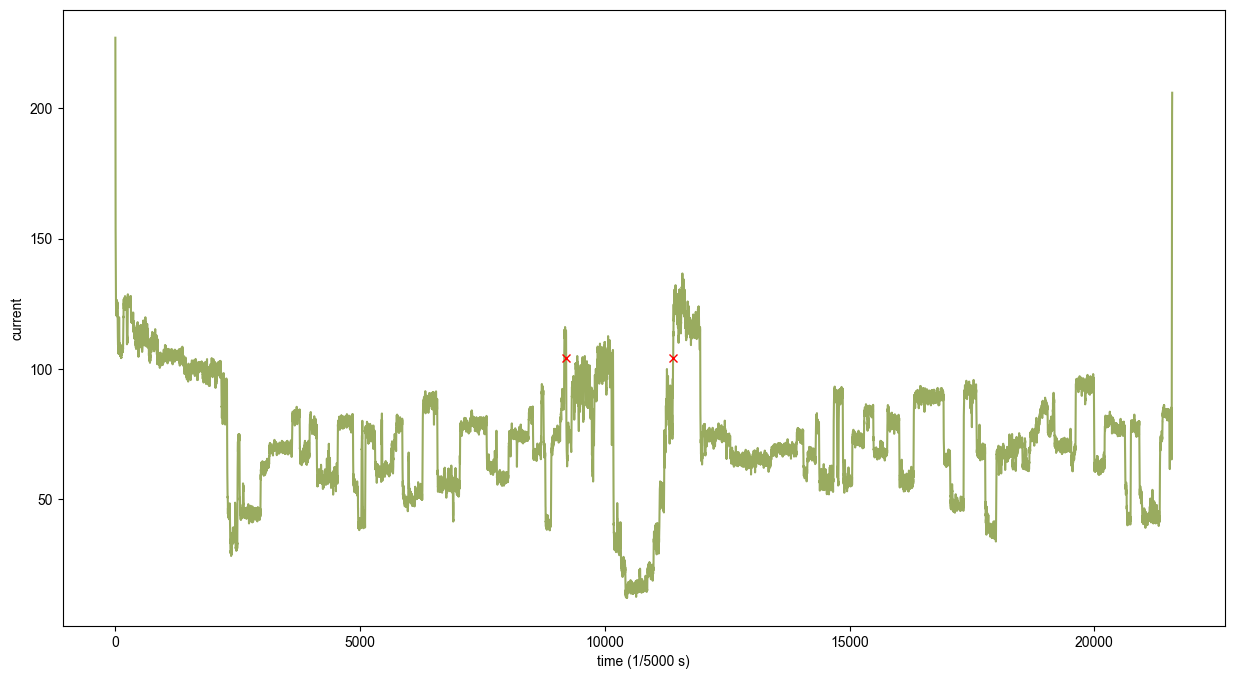

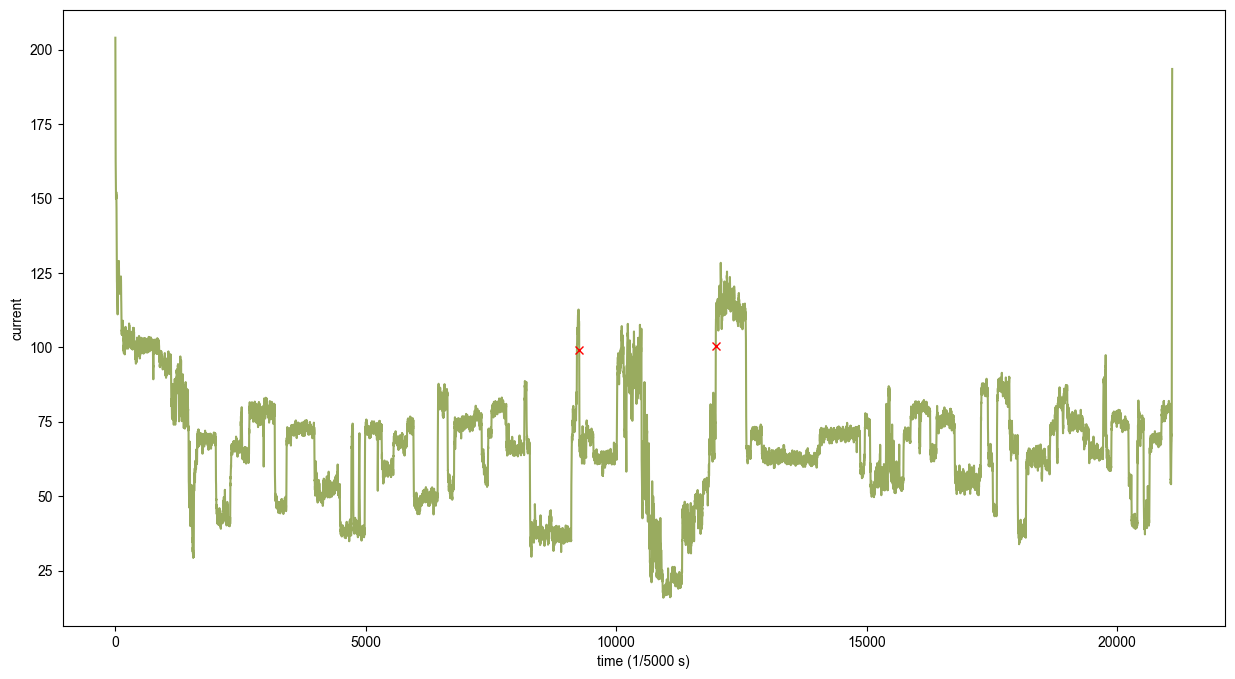

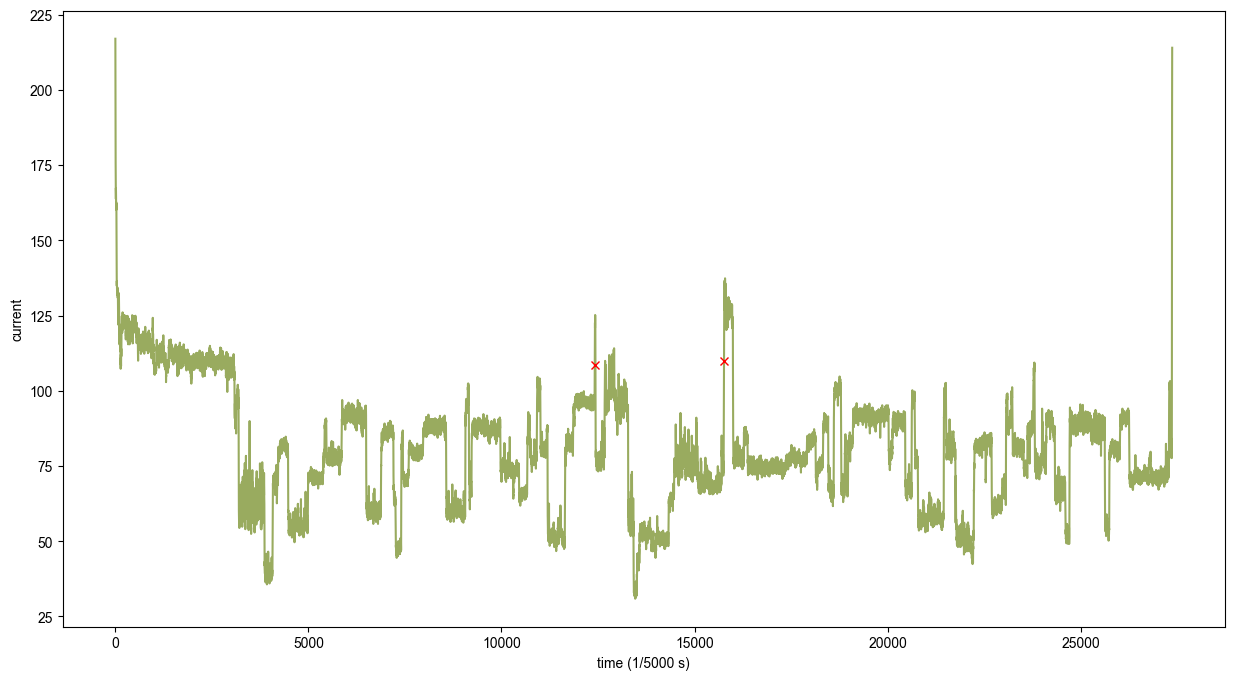

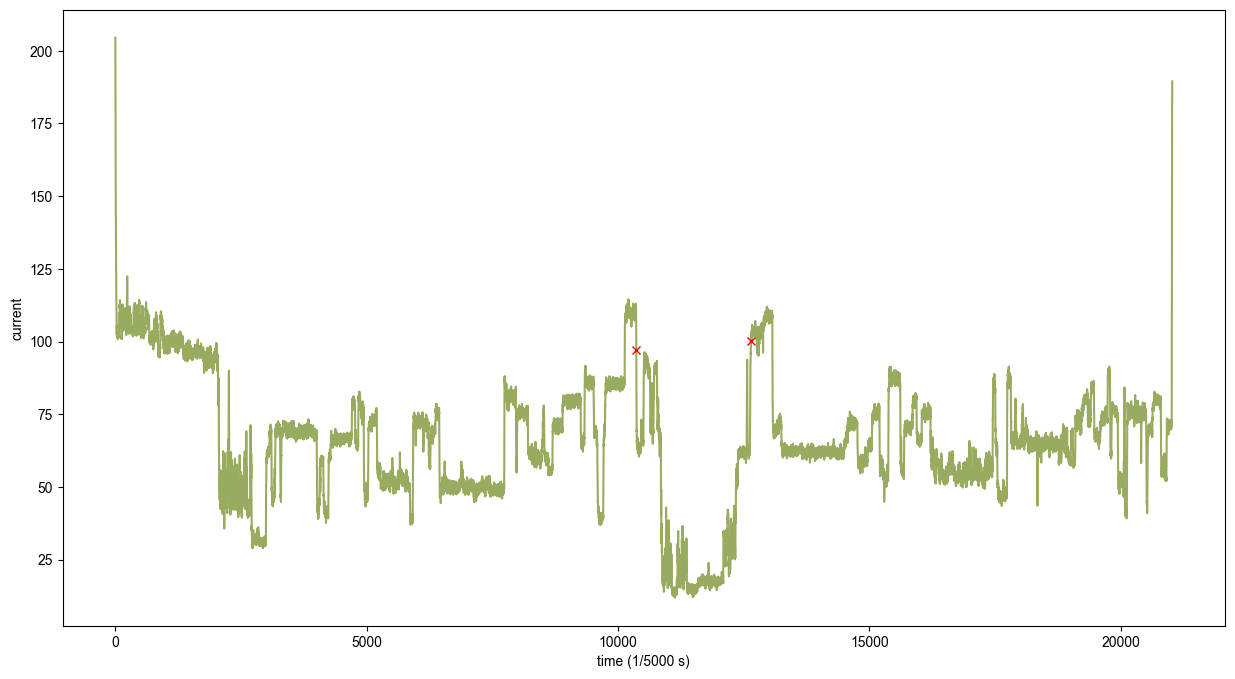

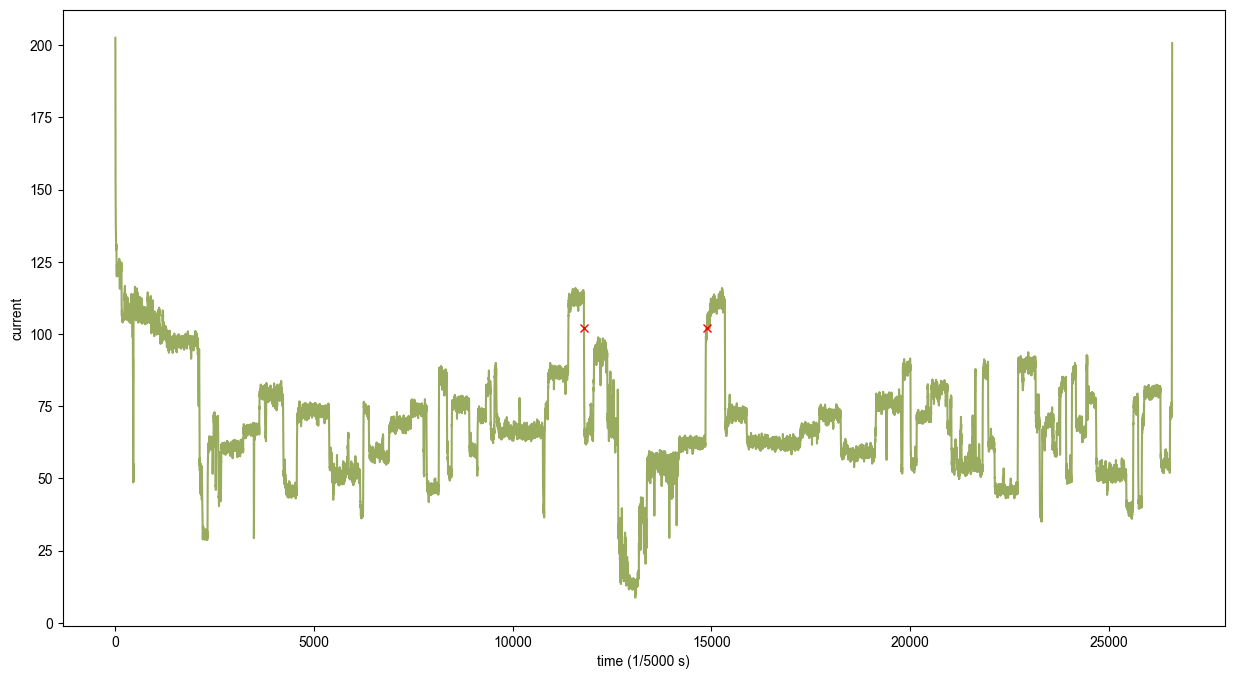

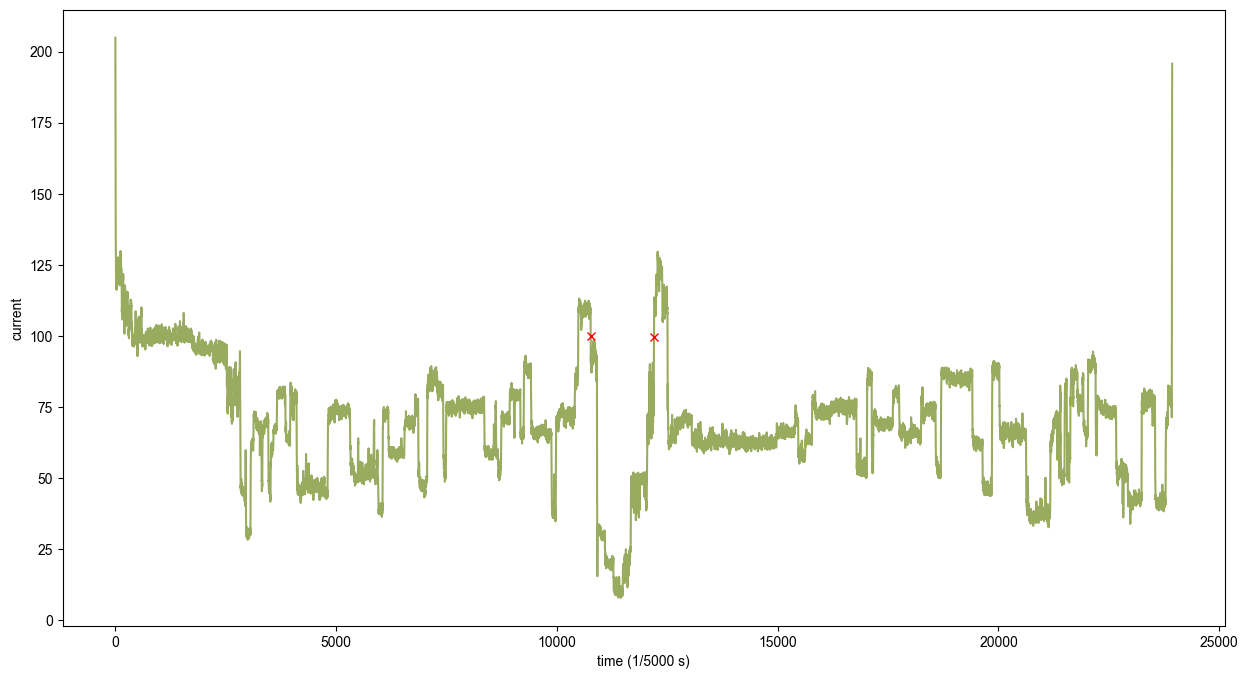

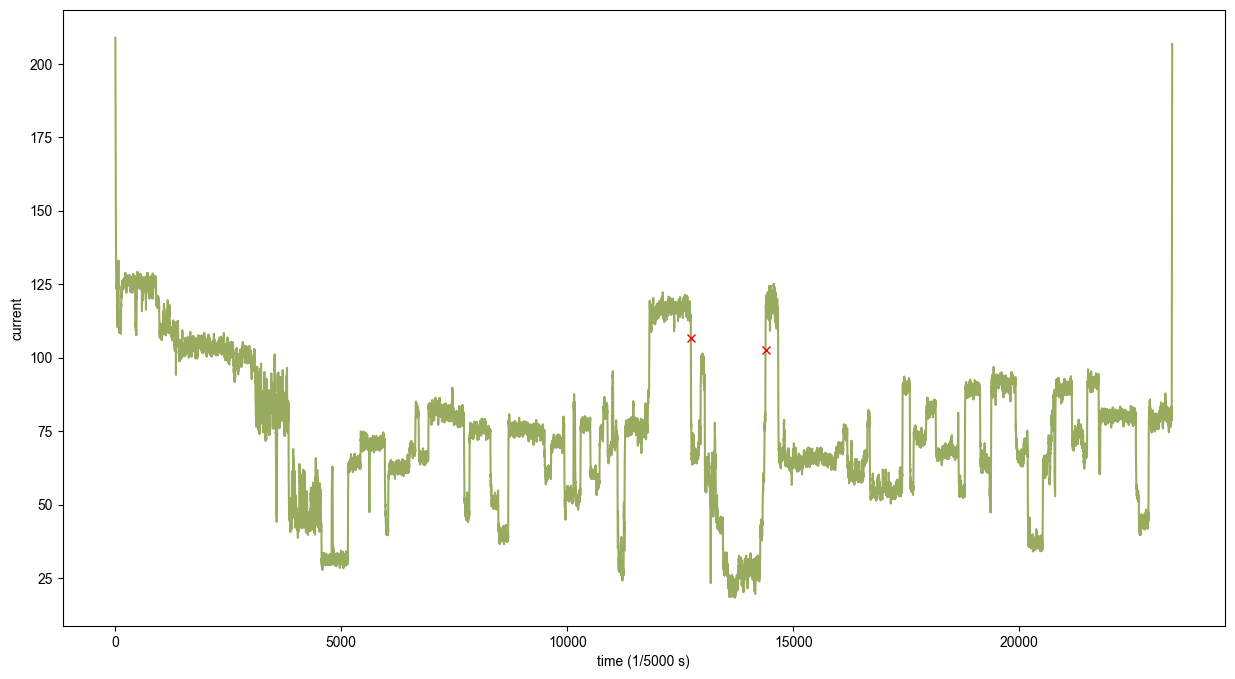

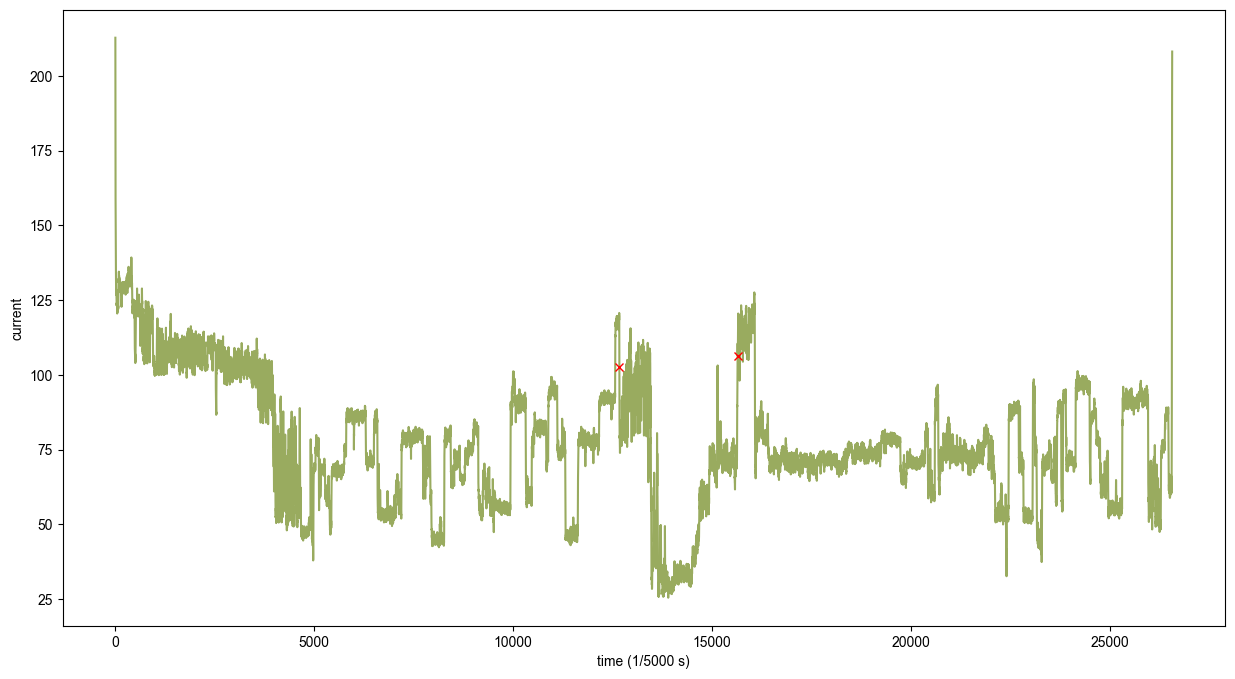

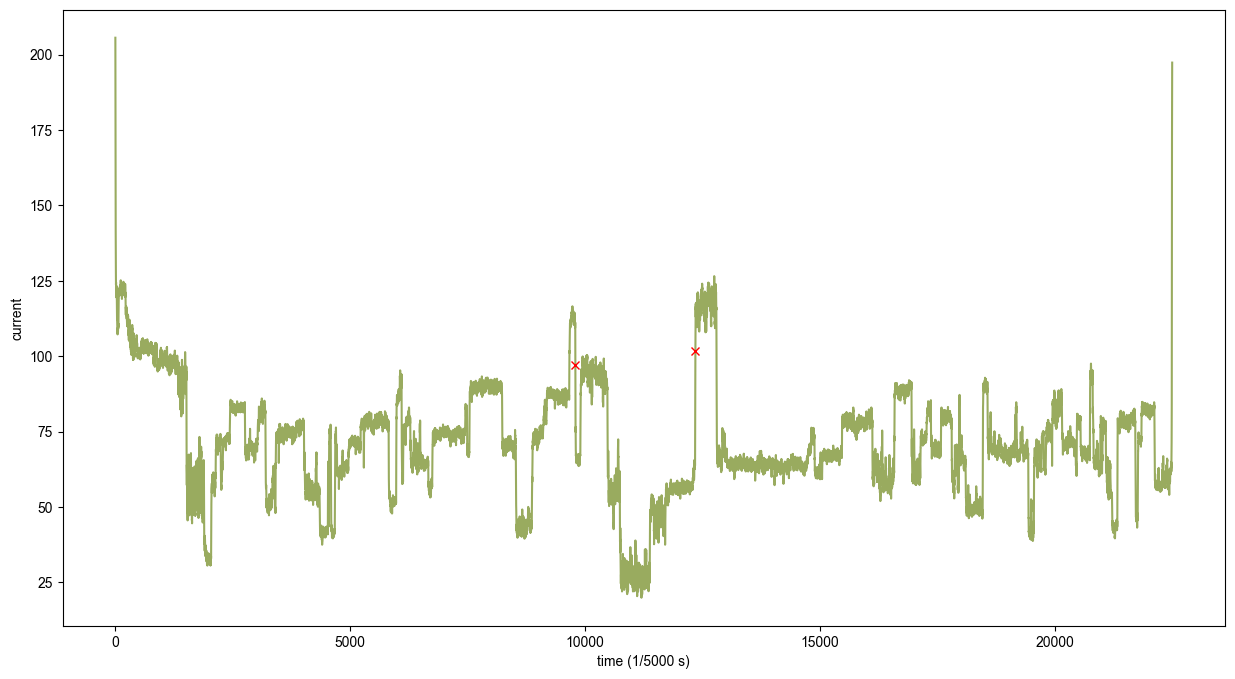

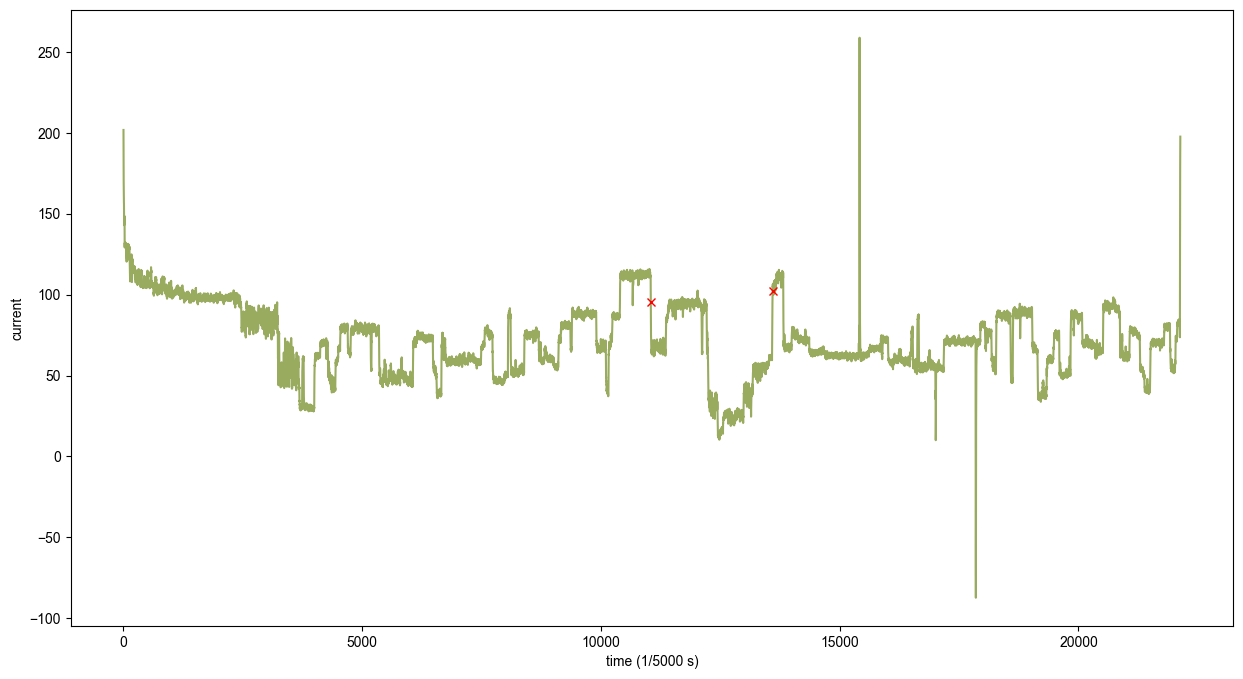

In [16]:
for i in range(10):
    nps.pl.draw_one_read_with_window(obj, pred_df[pred_df['pred']=='clean'].index[i])

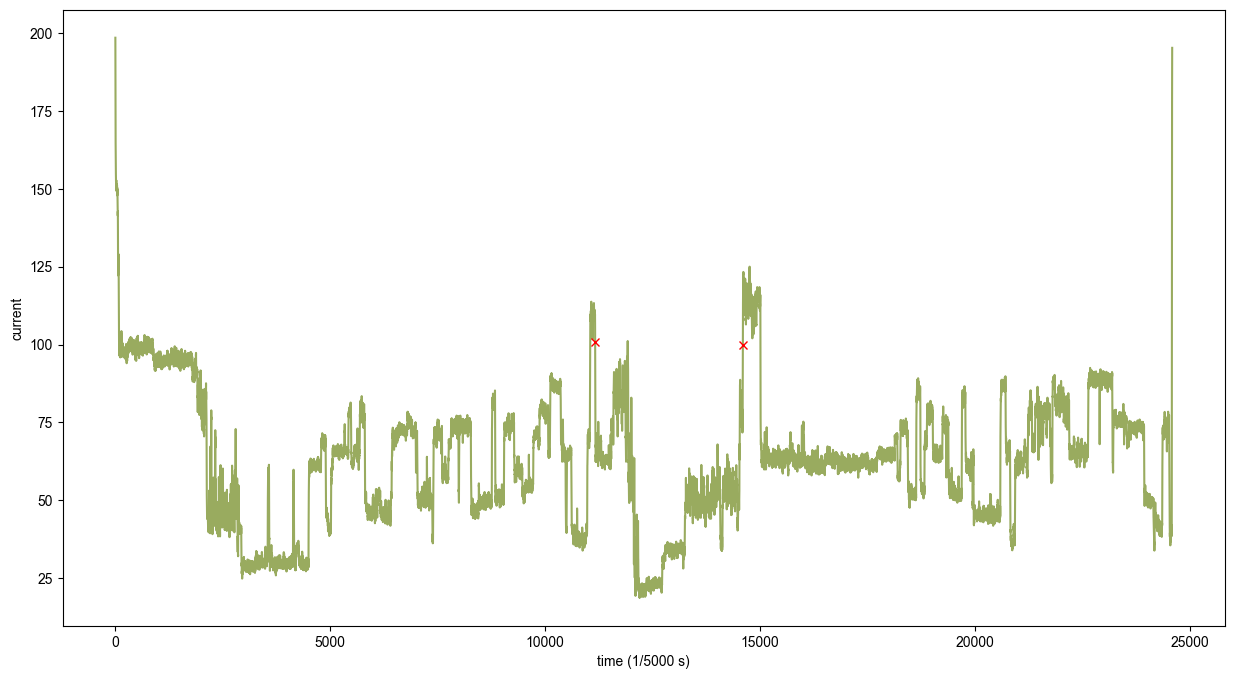

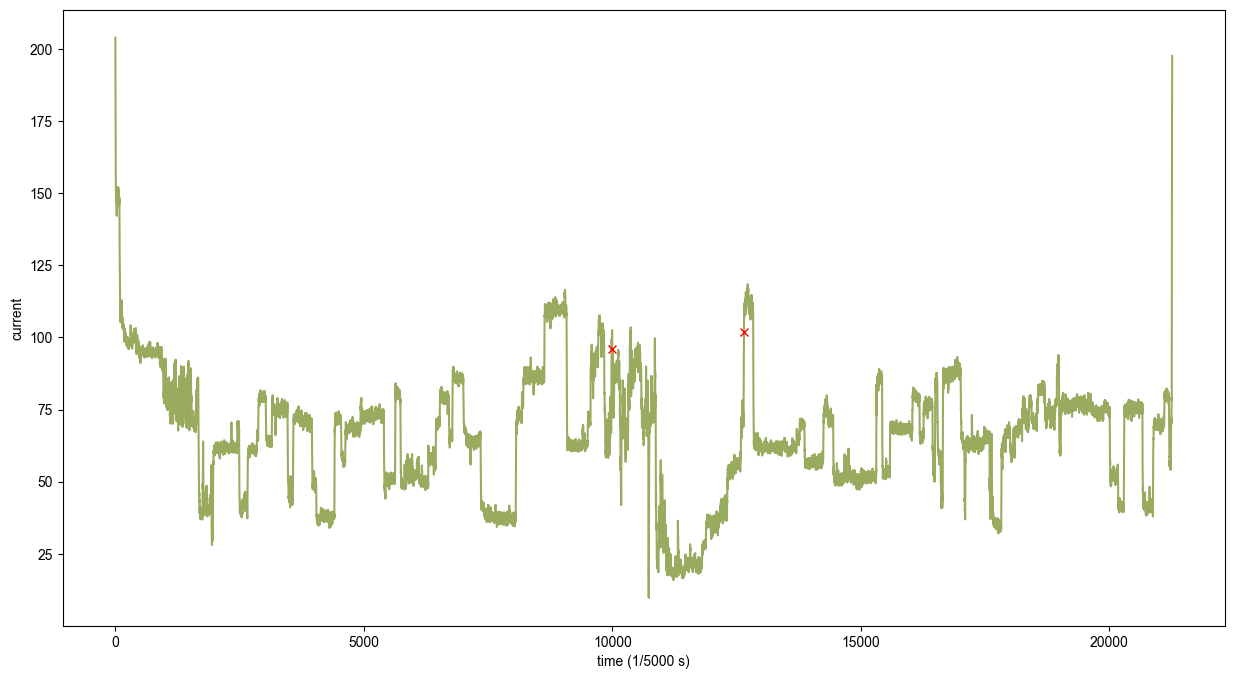

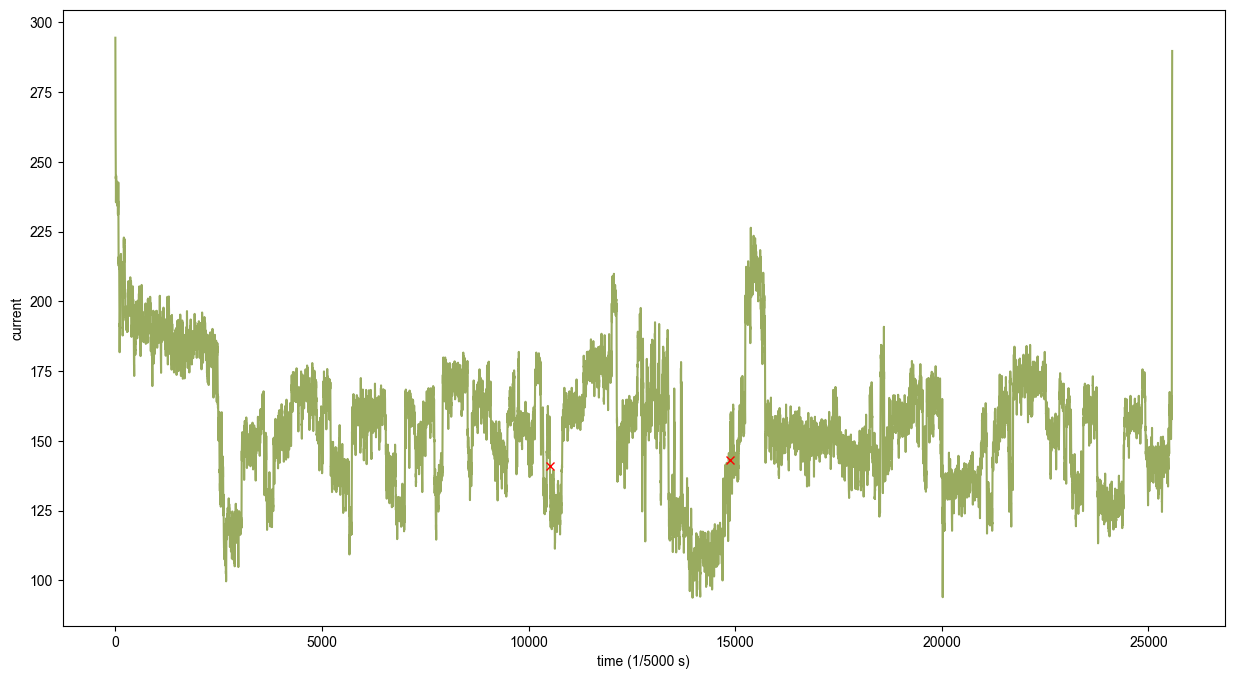

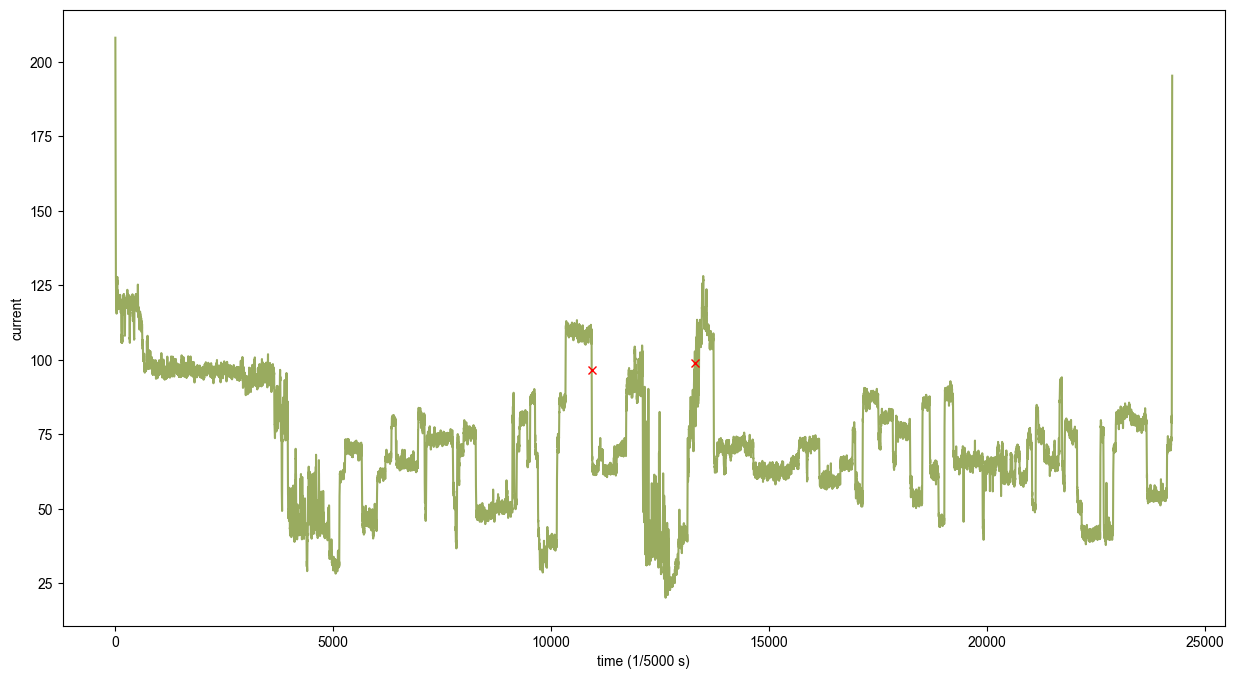

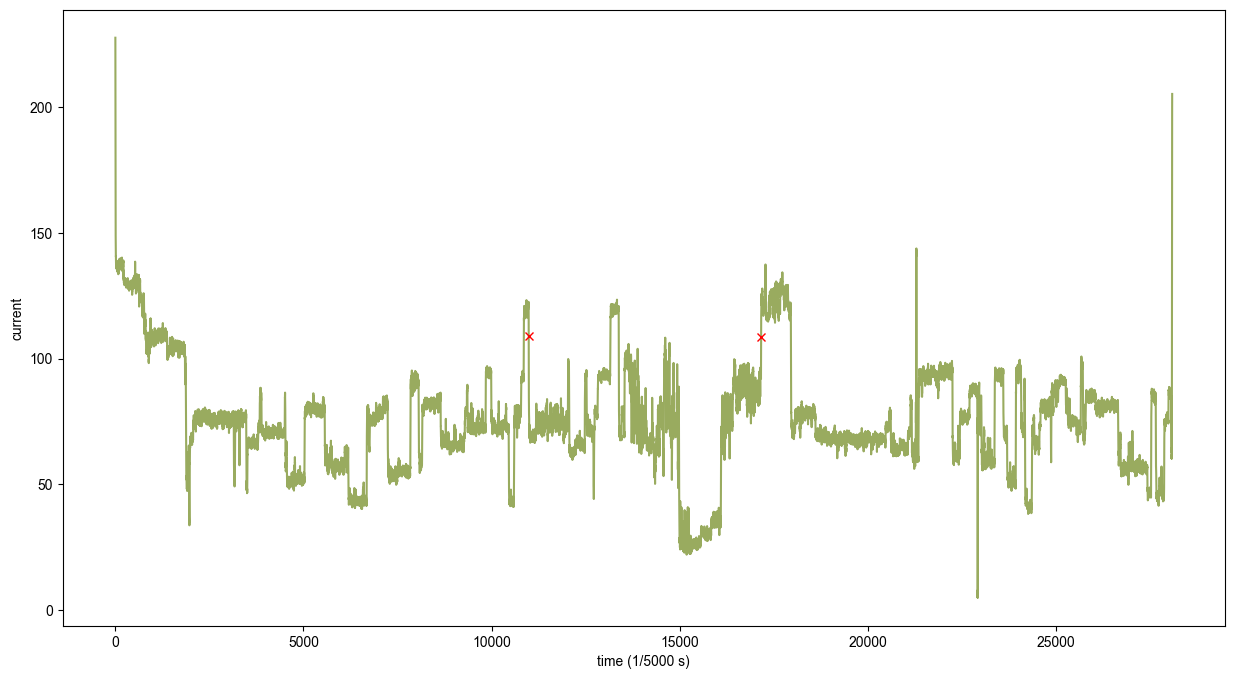

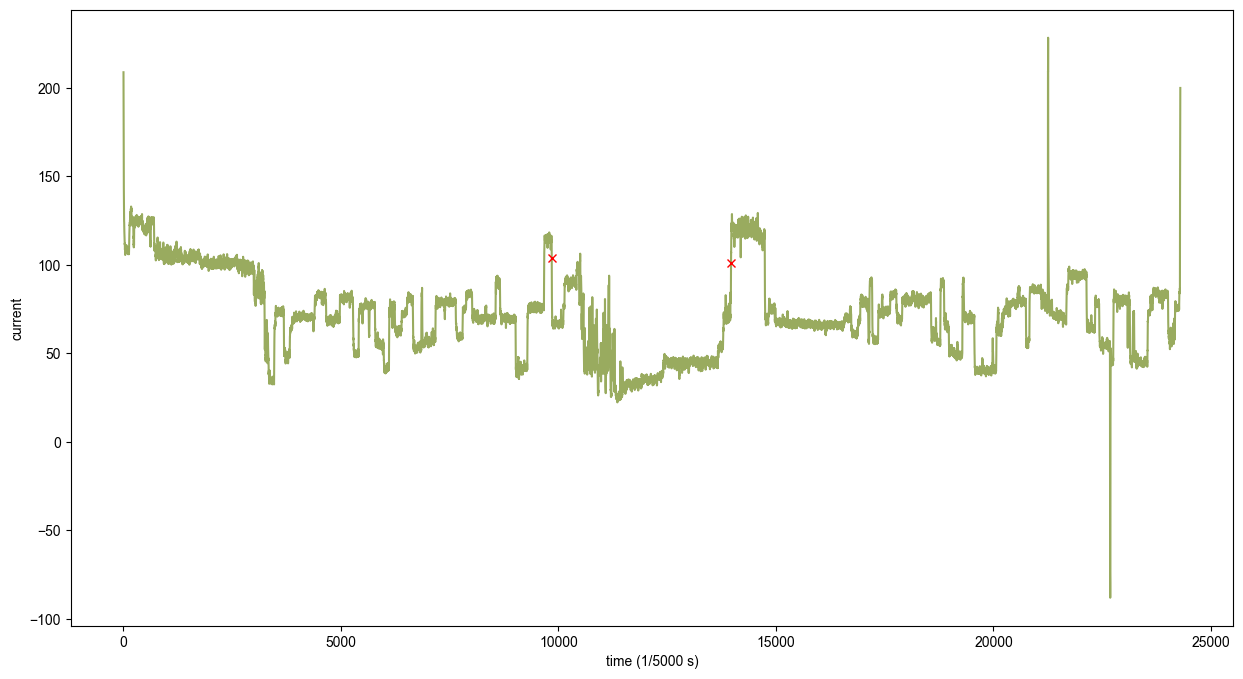

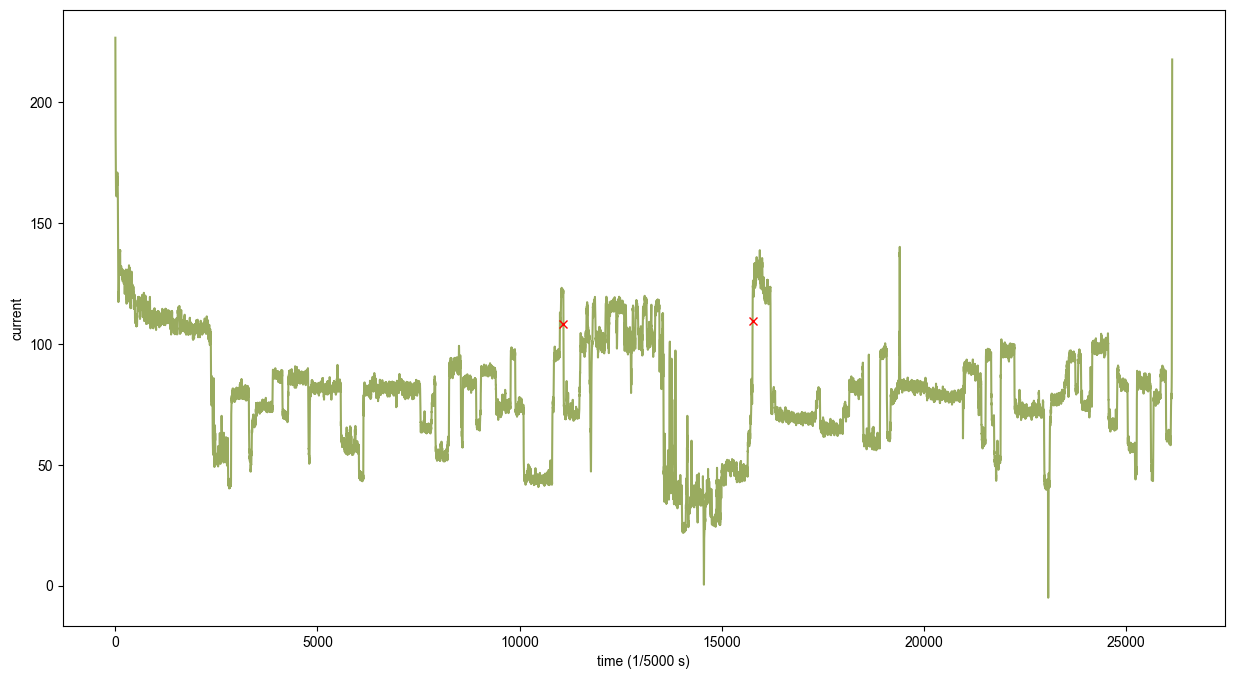

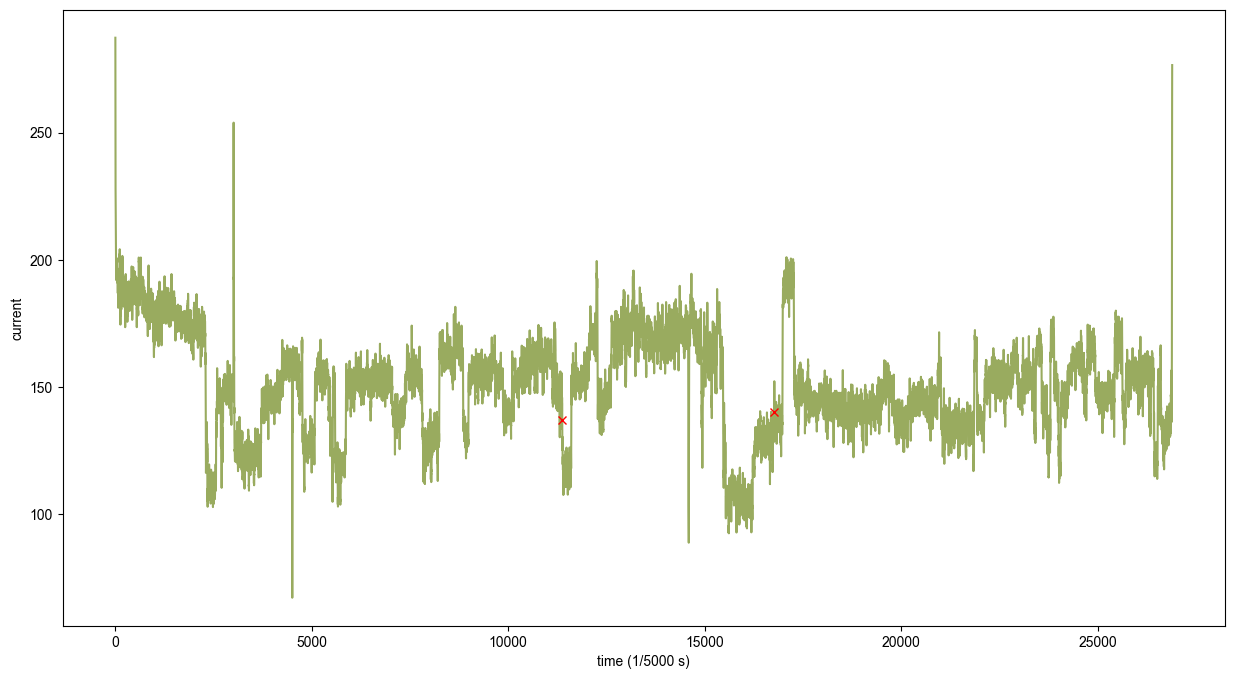

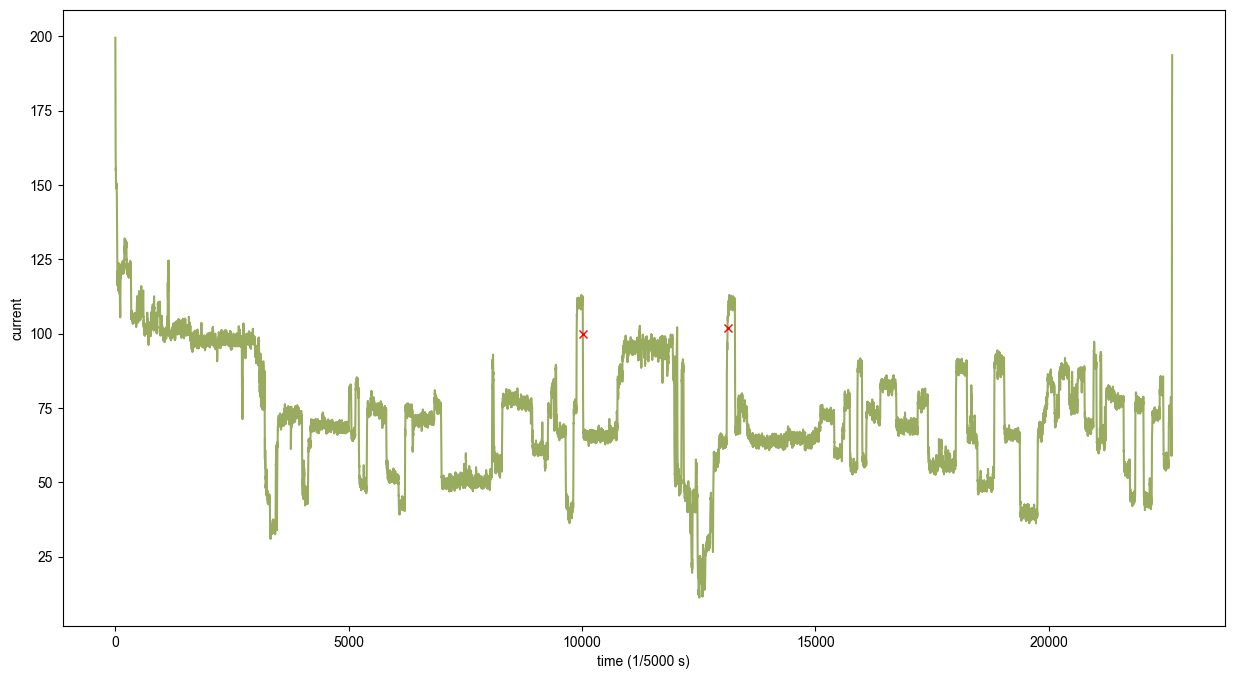

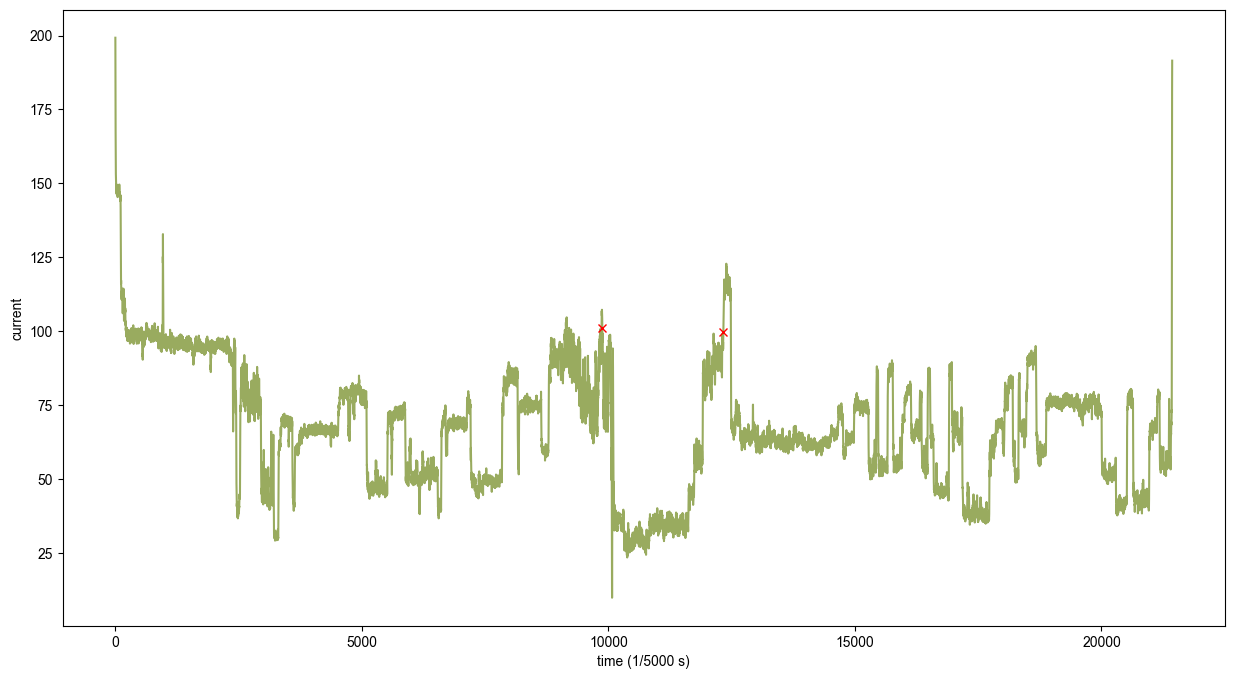

In [17]:
for i in range(10):
    nps.pl.draw_one_read_with_window(obj, pred_df[pred_df['pred']=='rejected'].index[i])

In [18]:
all_pred_df = []
for pep in all_peps:
    print(f'===={pep}====')
    obj = nps.io.read_pickle(f"../../../00.data/{pep}_valid20.pkl")
    test_objs = [obj]
    test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=['clean'], y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
    test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)
    pred_df = clf.predict(test_dl, name='cls_clean_and_rejected', y_to_label_dict=y_to_label_dict)
    all_pred_df.append(pred_df)
all_pred_df = pd.concat(all_pred_df)

====hp1_1====
 test_acc: 0.6043
====hp1_2====
 test_acc: 0.6817
====hp1_3====
 test_acc: 0.7070
====hp1_4====
 test_acc: 0.6731
====hp1_5====
 test_acc: 0.6790
====hp1_6====
 test_acc: 0.7045
====hp1_7====
 test_acc: 0.6770
====hp1_8====
 test_acc: 0.6849
====hp1_9====
 test_acc: 0.6643
====hp2_1====
 test_acc: 0.6866
====hp2_2====
 test_acc: 0.6551
====hp2_3====
 test_acc: 0.6896
====hp2_4====
 test_acc: 0.5894
====hp2_5====
 test_acc: 0.6773
====hp2_6====
 test_acc: 0.6453


In [19]:
all_pred_df.to_csv('../../../04.tables/classification_for_real_data/hp12/valid20_clean_or_rejected.csv')

In [20]:
all_pred_df = pd.read_csv('../../../04.tables/classification_for_real_data/hp12/valid20_clean_or_rejected.csv', index_col=0)
all_pred_df['pep'] = [re.search(r'(hp\d+_\d+)_', i).group(1) for i in all_pred_df.index]
all_pred_stat_df = all_pred_df.groupby(['pep', 'pred']).size().reset_index(name='count')
all_pred_stat_df = all_pred_stat_df.pivot_table(index='pep', columns='pred', values='count')
all_pred_stat_df['clean_ratio'] = all_pred_stat_df['clean'] / (all_pred_stat_df['rejected'] + all_pred_stat_df['clean'])
all_pred_stat_df.to_csv('../../../04.tables/classification_for_real_data/hp12/valid20_clean_or_rejected_stat.csv')
all_pred_stat_df

pred,clean,rejected,clean_ratio
pep,,,
hp1_1,9676.0,6335.0,0.604335
hp1_2,27190.0,12694.0,0.681727
hp1_3,18485.0,7660.0,0.707019
hp1_4,12572.0,6105.0,0.673127
hp1_5,11227.0,5307.0,0.679025
hp1_6,13143.0,5514.0,0.704454
hp1_7,15638.0,7462.0,0.676970
hp1_8,6192.0,2849.0,0.684880
hp1_9,9378.0,4740.0,0.664258
